In [29]:
import pysam as ps
import pandas as pd
import pyranges as pr
import numpy as np
from intervaltree import IntervalTree
from scipy.sparse import dok_matrix
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#peakspath=sys.argv[1]
#genespath=sys.argv[2]
#bampath=sys.argv[3]
#outpath=sys.argv[4]

peakspath = "/no_backup/mirimia/jchamberlin/data/arnau/nvec01/bambu_out_newgtf/paraclu/paraclu.peaks.filt.bed"
genespath = "/no_backup/mirimia/jchamberlin/refs/Nvec_DToL/Nvec_v4_merged_annotation_sort.add_gene.gtf"
bampath = "/no_backup/mirimia/jchamberlin/data/arnau/nvec01/bambu_out_newgtf/Bambu.demultiplexed.bam"

# import the peaks and genes, assign bam file
peaks = pr.read_bed(peakspath)
genes = pr.read_gtf(genespath)
bam = ps.AlignmentFile(bampath, "rb" )

# keep genes only
genes = genes[genes.Feature == "gene"].copy()

# filter out the antisense artifact peaks
peaks = peaks[~peaks.Name.isin(peaks.join(peaks, strandedness="opposite",suffix="_AS").
                               df.query("Score_AS >= 100 * Score").Name)]

peaks = peaks.df

# split tss and pas peaks, reset index so index = row number
tss_peaks = peaks[peaks.Name.str.contains("tss")].reset_index(drop=True)
pas_peaks = peaks[peaks.Name.str.contains("pas")].reset_index(drop=True)

# generate the tree dictionary thingies
tss_trees = {}
pas_trees = {}

for peak in tss_peaks.itertuples():
    key = (peak.Chromosome, peak.Strand)
    tss_trees.setdefault(key, IntervalTree()).addi(
        int(peak.Start),
        int(peak.End),
        peak.Index
    )
    
for peak in pas_peaks.itertuples():
    key = (peak.Chromosome, peak.Strand)
    pas_trees.setdefault(key, IntervalTree()).addi(
        int(peak.Start),
        int(peak.End),
        peak.Index
    )

contact_matrix = dok_matrix((len(tss_peaks),len(pas_peaks)), dtype=np.int64)
# empty vector to hold tss counts:
tss_counts = np.zeros(len(tss_peaks), dtype=np.int64)
pas_counts = np.zeros(len(pas_peaks), dtype=np.int64)

contact_length_counts = defaultdict(lambda: defaultdict(int))

for read in bam.fetch():
    if not(read.is_secondary or read.is_supplementary):
        
        # assign read boundaries to pas/tss points
        if read.is_reverse:
            read_strand = "-"
            peak_strand = "+"
            read_pas_pos = read.reference_end - 1
            read_tss_pos = read.reference_start
        else: 
            read_strand = "+"
            peak_strand = "-"
            read_pas_pos = read.reference_start
            read_tss_pos = read.reference_end - 1
            
        chrom = read.reference_name
        
        # for the peak indices:
        start_pid = None
        end_pid = None

        # if the read is on a chromosome with peaks
        if (chrom, peak_strand) in tss_trees:
            # Find start peak at 5' position
            tss_hits = tss_trees[(chrom, peak_strand)].overlap(read_tss_pos, read_tss_pos + 1)
            if tss_hits:
                start_pid = list(tss_hits)[0].data
                tss_counts[start_pid] += 1

        # Find end peak at 3' position
        if (chrom, peak_strand) in pas_trees:
            pas_hits = pas_trees[(chrom, peak_strand)].overlap(read_pas_pos, read_pas_pos + 1)
            if pas_hits:
                end_pid = list(pas_hits)[0].data
                pas_counts[end_pid] += 1

        if start_pid is not None and end_pid is not None:
            contact_matrix[start_pid, end_pid] += 1
            contact_length_counts[(start_pid, end_pid)][read.query_alignment_length] += 1


# convert the sparse matrix to a DataFrame
rows, cols = zip(*contact_matrix.keys())
values = list(contact_matrix.values())

df = pd.DataFrame({
    "row_idx": rows,
    "col_idx": cols,
    "count": values,
})

# Add row and column names by mapping indices
df["tss_peak_name"] = df["row_idx"].map(lambda i: tss_peaks.Name[i])
df["pas_peak_name"] = df["col_idx"].map(lambda i: pas_peaks.Name[i])

#df.to_csv(sys.argv[4], index=False, sep="\t", header=True)
#print(f"Output written to {sys.argv[4]}")
print(f"Total reads in peaks matrix: {contact_matrix.sum()}")

Total reads in peaks matrix: 92350791


In [30]:
from statistics import median

medians = {k: median([val for val, cnt in v.items() for _ in range(cnt)])
           for k, v in contact_length_counts.items()}

In [39]:
df["median_aln_length"] = medians.values()
df["idx_check"] = medians.keys()

In [51]:
df["tss_reads"] = df["tss_peak_name"].str.split("_").str[1].astype(int)
df["pas_reads"] = df["pas_peak_name"].str.split("_").str[1].astype(int)

In [53]:
df["total_reads"] = df["tss_reads"] + df["pas_reads"] - df["count"]

In [57]:
df["span_frac"] = df["count"] / df["total_reads"]

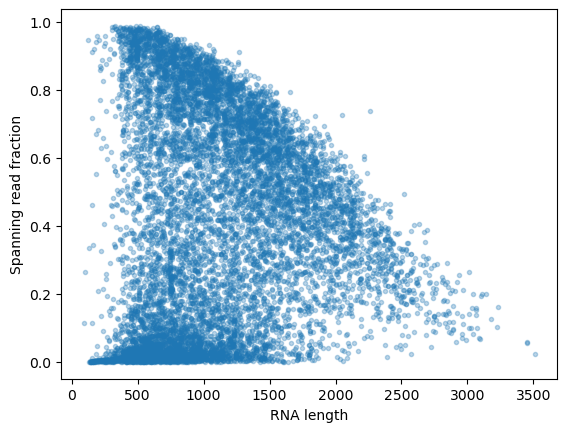

In [75]:
dff = df[df["count"] > 500].copy()


plt.plot((dff['median_aln_length']),dff['span_frac'],linestyle='none',marker=".",alpha=.3)
plt.xlabel("RNA length")
plt.ylabel("Spanning read fraction")
plt.show()

In [77]:
# filter out the peak pairs with <20% connection rate 
# which I think are mostly artifact PAS/TSS or genes with multiple PAS/TSS
dff["length_bin"] = pd.qcut(dff["median_aln_length"], q=20)

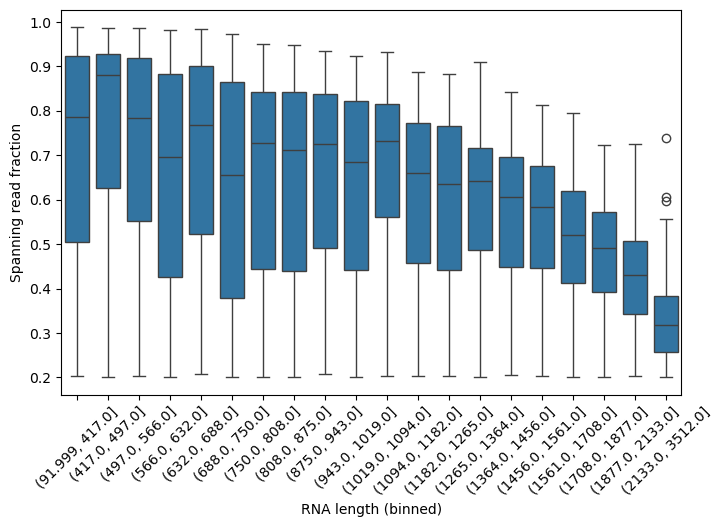

In [83]:
dfff = dff[dff["span_frac"] > .2].copy()

plt.figure(figsize=(8,5))
sns.boxplot(x="length_bin",y="span_frac", data=dfff)
plt.xticks(rotation=45)  # rotate labels 45 degrees
plt.xlabel('RNA length (binned)')
plt.ylabel("Spanning read fraction")
plt.show()

In [86]:
len(dfff),len(dff),len(df)

(7103, 10573, 20718)

In [87]:
dff["span_rat_bin"] = pd.qcut(dff["span_frac"], q=10)

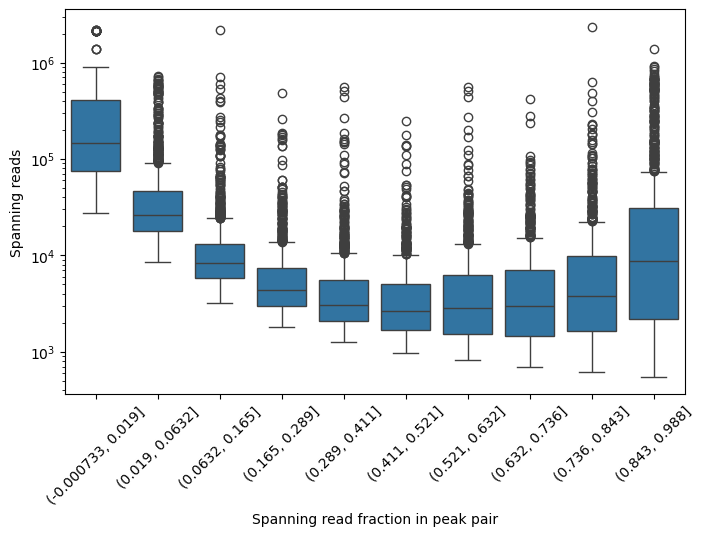

In [92]:
plt.figure(figsize=(8,5))
sns.boxplot(x="span_rat_bin",y="total_reads", data=dff)
plt.xticks(rotation=45)  # rotate labels 45 degrees
plt.xlabel('Spanning read fraction in peak pair')
plt.ylabel("Spanning reads")
plt.yscale('log')
plt.show()

# probably this is because the lowly spanning peaks are a result of (PAS count >>> TSS count), i.e.,
# the gene has multiple TSS or multiple PAS 